# Lower limits of detection of Malaria Parasites in dried blood spots when using Mid-Infrared Spectroscopy and Machine Learning approaches in presence and absence of anemia 


##  Importing all useful Libraries for our analyis ##

In [1]:
#Import impontant modules

import numpy as np 
import pandas as pd  
import scipy.stats as stats

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold

#Import ML classifiers
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

import os
import ast
import itertools
import collections
from time import time
from tqdm import tqdm 
import collections
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting


## Prepare confusion matrix plots

In [2]:

def plot_confusion_matrix(cm, classes,
                          normalise=True,
                          text=False,
                          title='Confusion matrix',color='r',
                          xrotation=0,
                          yrotation=0,
                          saturation=2,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalise=True'.
    """

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "{0} (normalised)".format(title)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0.009,0.91], ["Positive", 'Negative'],fontsize=18)
    plt.yticks([0.008,0.81], ["Positive", 'Negative'],fontsize=18,rotation=90)

    if text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]),
                                      range(cm.shape[1])):
            plt.text(j, i, "{0:.2f}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color= 'black',fontsize=20, Weight="bold")
    plt.xlabel('Predicted label', color='black',fontsize=20, Weight="bold")

## Validation for parasitemia 6% vs 0% at Moderate Anemia (25HMT)

### First we will load the best classifier trained with highest parasitemia of non_anemic sample

In [3]:
import joblib
import pickle
# Unpickle the model from the file
with open('Malaria_classifier.pk2', 'rb') as file:
    loaded_Malaria_Classifer = pickle.load(file)

# # Specify the filename used to save the model in the first script
# model_filename = 'Model_01_With_Few_wave_numbers_.joblib'
# # Load the model
# loaded_Malaria_Classifer = joblib.load(model_filename)



In [4]:
############import the 25HMT dataset
Validation_25HM_Parasitemias=pd.read_csv('Moderate_Anemia_25HM_alldata.csv') # Loading all data
print (Validation_25HM_Parasitemias)

######################### filter respective parasitemia 
validation25 = Validation_25HM_Parasitemias[(Validation_25HM_Parasitemias["Cat5"] == '6PRS') | (Validation_25HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation25.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation25["Cat5"]=validation25["Cat5"].replace({'6PRS': 'Positive', '0PRS': 'Negative'})
print (validation25)

#######################

# Select targets and features
X = validation25.iloc[:,3:]
Y = validation25["Cat5"]
print(X)

#######################

# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
#Predict this new Data set
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 6PRS at 25HMT:%.2f%%" %(accuracy * 100.0))


      Unnamed: 0  Cat4        Cat5    3855    3853    3851    3849    3847  \
0             20  25HM  0.00003PRS  0.0143  0.0139  0.0158  0.0171  0.0168   
1             21  25HM  0.00003PRS  0.0153  0.0151  0.0151  0.0153  0.0154   
2             22  25HM  0.00003PRS  0.0157  0.0154  0.0151  0.0151  0.0155   
3             23  25HM  0.00003PRS  0.0172  0.0175  0.0155  0.0144  0.0150   
4             24  25HM  0.00003PRS  0.0198  0.0201  0.0183  0.0171  0.0173   
...          ...   ...         ...     ...     ...     ...     ...     ...   
1461        4529  25HM        6PRS  0.0126  0.0122  0.0122  0.0124  0.0126   
1462        4530  25HM        6PRS  0.0130  0.0130  0.0129  0.0130  0.0131   
1463        4531  25HM        6PRS  0.0132  0.0130  0.0148  0.0158  0.0154   
1464        4532  25HM        6PRS  0.0133  0.0128  0.0146  0.0158  0.0155   
1465        4533  25HM        6PRS  0.0133  0.0134  0.0135  0.0137  0.0139   

        3845    3843  ...     545     543     541     539     5

<ipython-input-4-65194209d8d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation25["Cat5"]=validation25["Cat5"].replace({'6PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 130, 'Positive': 130})
[[0.28571429 0.24761905 0.35051546 ... 0.55753262 0.62020906 0.66858458]
 [0.32653061 0.3047619  0.27835052 ... 0.48754448 0.53310105 0.55235903]
 [0.33673469 0.33333333 0.31958763 ... 0.39620403 0.46689895 0.55811277]
 ...
 [0.68367347 0.66666667 0.65979381 ... 0.66429419 0.67479675 0.73302647]
 [0.74489796 0.76190476 0.60824742 ... 0.72360617 0.728223   0.67663982]
 [0.40816327 0.40952381 0.37113402 ... 0.54685647 0.4912892  0.37514384]]
Accuracy on validation 6PRS at 25HMT:100.00%


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Model accuracy is reported on the test set. 10 bootstrapped samples Median accuracy is 1.00 with a 95% a confidence interval of [1.00,1.00].


C:\Users\Issa Mshani\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


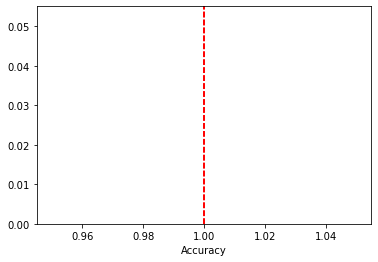

In [5]:
n_bootstrap_samples = 100

# An array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)

    # Make predictions using the already trained model
    y_pred =  loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# get median
median = np.percentile(validation_scores, 50)

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()


Normalized confusion matrix


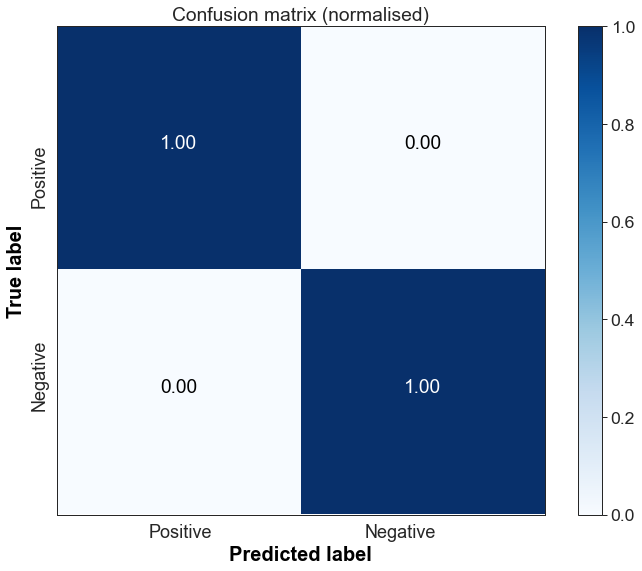

In [6]:
# plotting confusion matrix 

from matplotlib import rcParams

sns.set(context="paper",

    style="white",

    font_scale=2.0,
        
    rc={"font.family": "sans-serif"})
#
rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams["figure.figsize"] = [10,8]
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 

In [7]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       130
    Positive       1.00      1.00      1.00       130

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



# Validation for Parasitemia 0.1% vs 0% at 25HMT

In [8]:
############import the 25HMT dataset
Validation_25HM_Parasitemias=pd.read_csv('Moderate_Anemia_25HM_alldata.csv') # Loading all data
print (Validation_25HM_Parasitemias)

######################### filter respective parasitemia 
validation25 = Validation_25HM_Parasitemias[(Validation_25HM_Parasitemias["Cat5"] == '0.1PRS') | (Validation_25HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation25.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation25["Cat5"]=validation25["Cat5"].replace({'0.1PRS': 'Positive', '0PRS': 'Negative'})
print (validation25)

#######################

# Select targets and features
X = validation25.iloc[:,3:]
Y = validation25["Cat5"]
print(X)

#######################

# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
#Predict this new Data set
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 0.1PRS at 25HMT:%.2f%%" %(accuracy * 100.0))


      Unnamed: 0  Cat4        Cat5    3855    3853    3851    3849    3847  \
0             20  25HM  0.00003PRS  0.0143  0.0139  0.0158  0.0171  0.0168   
1             21  25HM  0.00003PRS  0.0153  0.0151  0.0151  0.0153  0.0154   
2             22  25HM  0.00003PRS  0.0157  0.0154  0.0151  0.0151  0.0155   
3             23  25HM  0.00003PRS  0.0172  0.0175  0.0155  0.0144  0.0150   
4             24  25HM  0.00003PRS  0.0198  0.0201  0.0183  0.0171  0.0173   
...          ...   ...         ...     ...     ...     ...     ...     ...   
1461        4529  25HM        6PRS  0.0126  0.0122  0.0122  0.0124  0.0126   
1462        4530  25HM        6PRS  0.0130  0.0130  0.0129  0.0130  0.0131   
1463        4531  25HM        6PRS  0.0132  0.0130  0.0148  0.0158  0.0154   
1464        4532  25HM        6PRS  0.0133  0.0128  0.0146  0.0158  0.0155   
1465        4533  25HM        6PRS  0.0133  0.0134  0.0135  0.0137  0.0139   

        3845    3843  ...     545     543     541     539     5

<ipython-input-8-20a8a1608b8f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation25["Cat5"]=validation25["Cat5"].replace({'0.1PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 130, 'Positive': 130})
[[0.3255814  0.27083333 0.38636364 ... 0.65       0.67687747 0.70357942]
 [0.37209302 0.33333333 0.30681818 ... 0.58979592 0.6027668  0.59060403]
 [0.38372093 0.36458333 0.35227273 ... 0.51122449 0.54644269 0.59619687]
 ...
 [0.56976744 0.5625     0.59090909 ... 0.78571429 0.81126482 0.74944072]
 [0.1744186  0.13541667 0.26136364 ... 0.60816327 0.65118577 0.60850112]
 [0.3255814  0.29166667 0.23863636 ... 0.35918367 0.28853755 0.19574944]]
Accuracy on validation 0.1PRS at 25HMT:100.00%


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Model accuracy is reported on the test set. 10 bootstrapped samples Median accuracy is 1.00 with a 95% a confidence interval of [1.00,1.00].


C:\Users\Issa Mshani\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


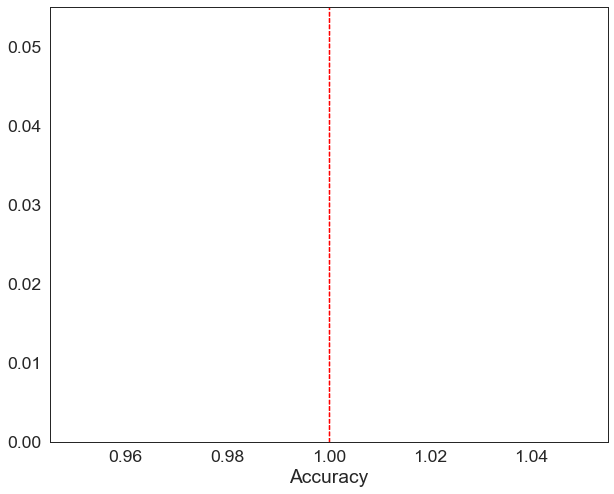

In [9]:
# we then validate the model with 100 bootstrap
n_bootstrap_samples = 100

# An array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# get median
median = np.percentile(validation_scores, 50)

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()


Normalized confusion matrix


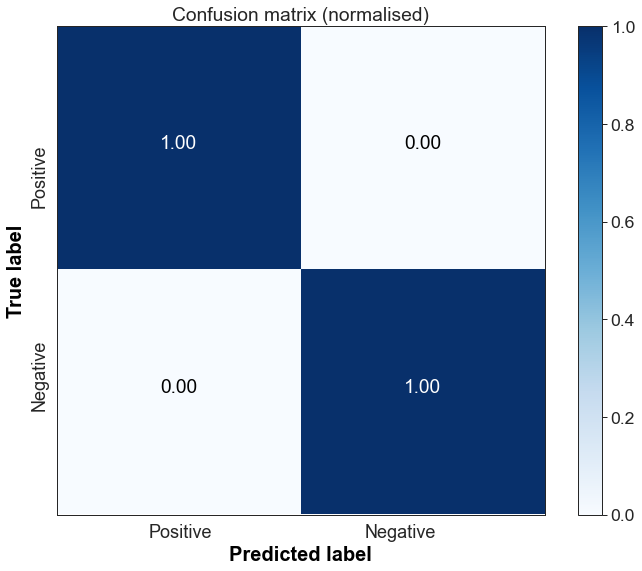

In [10]:
# plotting confusion matrix 
sns.set(context="paper",

    style="white",

    font_scale=2.0,
        
    rc={"font.family": "sans-serif"})

rcParams['font.sans-serif'] = 'Arial'

plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 

In [11]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       130
    Positive       1.00      1.00      1.00       130

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



# Validation for Parasitemia 0.002% vs 0% at 25HMT

In [12]:
############import the 25HMT dataset
Validation_25HM_Parasitemias=pd.read_csv('Moderate_Anemia_25HM_alldata.csv') # Loading all data
print (Validation_25HM_Parasitemias)

######################### filter respective parasitemia 
validation25 = Validation_25HM_Parasitemias[(Validation_25HM_Parasitemias["Cat5"] == '0.002PRS') | (Validation_25HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation25.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation25["Cat5"]=validation25["Cat5"].replace({'0.002PRS': 'Positive', '0PRS': 'Negative'})
print (validation25)

#######################

# Select targets and features
X = validation25.iloc[:,3:]
Y = validation25["Cat5"]
print(X)

#######################

# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
#Predict this new Data set
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 0.002PRS at 25HMT:%.2f%%" %(accuracy * 100.0))


      Unnamed: 0  Cat4        Cat5    3855    3853    3851    3849    3847  \
0             20  25HM  0.00003PRS  0.0143  0.0139  0.0158  0.0171  0.0168   
1             21  25HM  0.00003PRS  0.0153  0.0151  0.0151  0.0153  0.0154   
2             22  25HM  0.00003PRS  0.0157  0.0154  0.0151  0.0151  0.0155   
3             23  25HM  0.00003PRS  0.0172  0.0175  0.0155  0.0144  0.0150   
4             24  25HM  0.00003PRS  0.0198  0.0201  0.0183  0.0171  0.0173   
...          ...   ...         ...     ...     ...     ...     ...     ...   
1461        4529  25HM        6PRS  0.0126  0.0122  0.0122  0.0124  0.0126   
1462        4530  25HM        6PRS  0.0130  0.0130  0.0129  0.0130  0.0131   
1463        4531  25HM        6PRS  0.0132  0.0130  0.0148  0.0158  0.0154   
1464        4532  25HM        6PRS  0.0133  0.0128  0.0146  0.0158  0.0155   
1465        4533  25HM        6PRS  0.0133  0.0134  0.0135  0.0137  0.0139   

        3845    3843  ...     545     543     541     539     5

<ipython-input-12-247d1438c3ae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation25["Cat5"]=validation25["Cat5"].replace({'0.002PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 130, 'Positive': 130})
[[0.33333333 0.31372549 0.43037975 ... 0.49421661 0.45224007 0.47740345]
 [0.37931034 0.37254902 0.34177215 ... 0.43217666 0.38884193 0.39441249]
 [0.3908046  0.40196078 0.39240506 ... 0.35120925 0.34065934 0.39852095]
 ...
 [0.54022989 0.54901961 0.40506329 ... 0.48159832 0.41673711 0.41413311]
 [0.40229885 0.37254902 0.53164557 ... 0.553102   0.44125106 0.44617913]
 [0.50574713 0.52941176 0.32911392 ... 0.21451104 0.28317836 0.36154478]]
Accuracy on validation 0.002PRS at 25HMT:95.00%


[0.95384615 0.95       0.95769231 0.95769231 0.96538462 0.94615385
 0.97692308 0.95769231 0.93461538 0.95769231 0.95769231 0.93461538
 0.96153846 0.95384615 0.96153846 0.95769231 0.96153846 0.96153846
 0.98076923 0.93846154 0.94615385 0.94615385 0.97692308 0.92692308
 0.94615385 0.96923077 0.93846154 0.96538462 0.95       0.95769231
 0.96538462 0.95       0.95384615 0.93076923 0.9        0.93846154
 0.96153846 0.95769231 0.93461538 0.93076923 0.94615385 0.92307692
 0.94230769 0.96153846 0.94615385 0.97307692 0.96153846 0.95384615
 0.92692308 0.94230769 0.95769231 0.95769231 0.95       0.96923077
 0.93076923 0.97307692 0.94615385 0.93846154 0.93846154 0.94230769
 0.95384615 0.94615385 0.94230769 0.93461538 0.93846154 0.95384615
 0.96538462 0.95769231 0.93846154 0.96153846 0.95384615 0.93461538
 0.93461538 0.96153846 0.95384615 0.93076923 0.95384615 0.96923077
 0.93461538 0.94615385 0.96538462 0.95384615 0.96538462 0.94615385
 0.93846154 0.93846154 0.95769231 0.95       0.93076923 0.9307

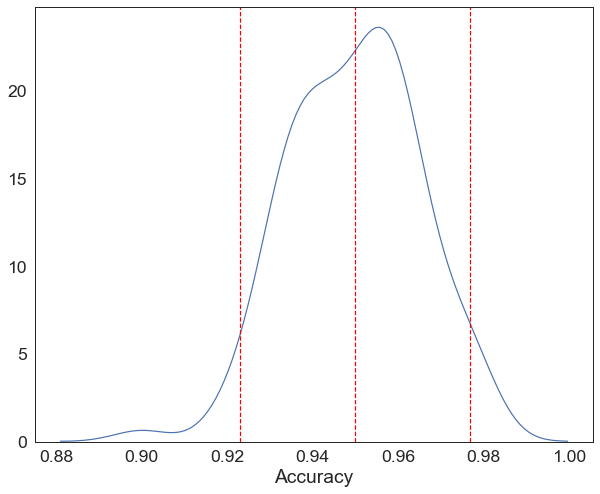

In [13]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# get median
median = np.percentile(validation_scores, 50)

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

Normalized confusion matrix


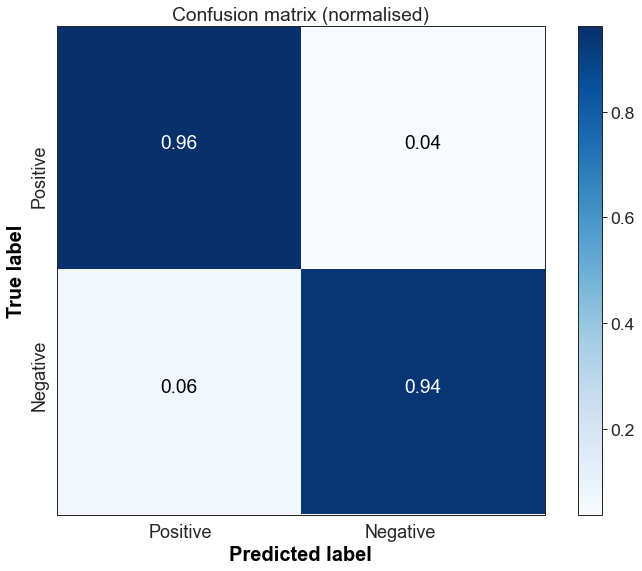

In [14]:
# plotting confusion matrix 
sns.set(context="paper",

    style="white",

    font_scale=2.0,
        
    rc={"font.family": "sans-serif"})

rcParams['font.sans-serif'] = 'Arial'

plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 
#plt.savefig("validation_Field_DE.png", dpi = 300, bbox_inches="tight")

In [15]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95       130
    Positive       0.96      0.94      0.95       130

    accuracy                           0.95       260
   macro avg       0.95      0.95      0.95       260
weighted avg       0.95      0.95      0.95       260



## Validation for Parasitemia 0.00003% vs 0% at 25HMT

In [17]:
############import the 25HMT dataset
Validation_25HM_Parasitemias=pd.read_csv('Moderate_Anemia_25HM_alldata.csv') # Loading all data
print (Validation_25HM_Parasitemias)

######################### filter respective parasitemia 
validation25 = Validation_25HM_Parasitemias[(Validation_25HM_Parasitemias["Cat5"] == '0.00003PRS') | (Validation_25HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation25.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation25["Cat5"]=validation25["Cat5"].replace({'0.00003PRS': 'Positive', '0PRS': 'Negative'})
print (validation25)

#######################

# Select targets and features
X = validation25.iloc[:,3:]
Y = validation25["Cat5"]
print(X)

#######################

# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
#Predict this new Data set
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 0.00003PRS at 25HMT:%.2f%%" %(accuracy * 100.0))

      Unnamed: 0  Cat4        Cat5    3855    3853    3851    3849    3847  \
0             20  25HM  0.00003PRS  0.0143  0.0139  0.0158  0.0171  0.0168   
1             21  25HM  0.00003PRS  0.0153  0.0151  0.0151  0.0153  0.0154   
2             22  25HM  0.00003PRS  0.0157  0.0154  0.0151  0.0151  0.0155   
3             23  25HM  0.00003PRS  0.0172  0.0175  0.0155  0.0144  0.0150   
4             24  25HM  0.00003PRS  0.0198  0.0201  0.0183  0.0171  0.0173   
...          ...   ...         ...     ...     ...     ...     ...     ...   
1461        4529  25HM        6PRS  0.0126  0.0122  0.0122  0.0124  0.0126   
1462        4530  25HM        6PRS  0.0130  0.0130  0.0129  0.0130  0.0131   
1463        4531  25HM        6PRS  0.0132  0.0130  0.0148  0.0158  0.0154   
1464        4532  25HM        6PRS  0.0133  0.0128  0.0146  0.0158  0.0155   
1465        4533  25HM        6PRS  0.0133  0.0134  0.0135  0.0137  0.0139   

        3845    3843  ...     545     543     541     539     5

<ipython-input-17-79ca3575dc6e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation25["Cat5"]=validation25["Cat5"].replace({'0.002PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 130, 'Positive': 130})
[[0.33333333 0.31372549 0.43037975 ... 0.54651163 0.59731544 0.58568548]
 [0.37931034 0.37254902 0.34177215 ... 0.47790698 0.51342282 0.48387097]
 [0.3908046  0.40196078 0.39240506 ... 0.38837209 0.44966443 0.48891129]
 ...
 [0.42528736 0.42156863 0.40506329 ... 0.42093023 0.44295302 0.3921371 ]
 [0.67816092 0.68627451 0.73417722 ... 0.43372093 0.41610738 0.35282258]
 [0.67816092 0.66666667 0.70886076 ... 0.71744186 0.68344519 0.67540323]]
Accuracy on validation 0.00003PRS at 25HMT:94.62%


## Run Validation with 100 bootstraps

[0.93846154 0.97307692 0.94615385 0.93461538 0.95769231 0.95769231
 0.93846154 0.94615385 0.95       0.94615385 0.93846154 0.95
 0.92692308 0.93076923 0.93076923 0.95769231 0.94615385 0.93461538
 0.95769231 0.94615385 0.92307692 0.96153846 0.93076923 0.92307692
 0.95384615 0.90384615 0.96538462 0.94615385 0.96538462 0.95
 0.97307692 0.94230769 0.95769231 0.94615385 0.95769231 0.95
 0.98461538 0.93461538 0.95       0.93846154 0.96923077 0.95384615
 0.93846154 0.94615385 0.95384615 0.95384615 0.95769231 0.95384615
 0.93076923 0.95       0.93076923 0.96538462 0.94615385 0.97307692
 0.93461538 0.94615385 0.94230769 0.94615385 0.93076923 0.94615385
 0.95384615 0.95769231 0.93076923 0.93076923 0.95       0.92692308
 0.95769231 0.96538462 0.95       0.95384615 0.91153846 0.92307692
 0.94230769 0.93076923 0.95769231 0.96923077 0.93846154 0.95769231
 0.96538462 0.95384615 0.94230769 0.92692308 0.94615385 0.94615385
 0.93846154 0.94615385 0.95769231 0.92307692 0.93461538 0.97692308
 0.94230769 0

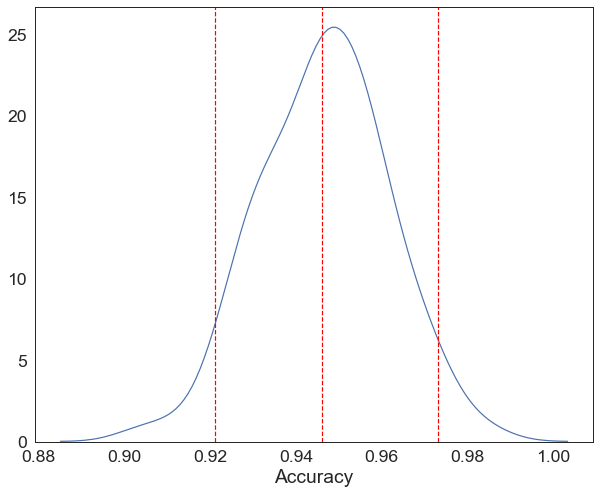

In [18]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# get median
median = np.percentile(validation_scores, 50)

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()


Normalized confusion matrix


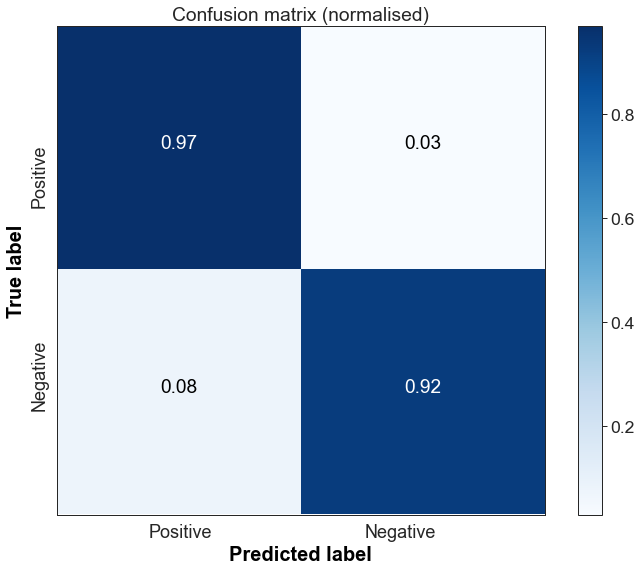

In [19]:
# plotting confusion matrix 
sns.set(context="paper",

    style="white",

    font_scale=2.0,
        
    rc={"font.family": "sans-serif"})

rcParams['font.sans-serif'] = 'Arial'

plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 